In [4]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
using DiffEqCallbacks
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using ProgressBars
using NonlinearSolve
using BenchmarkTools
using Libdl

In [5]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb, threshold_du, threshold_std, t_std, f_counter, save_sol)
    list_t, popup_t, nbr_error_t, sol_t, du_t = [], [], [], [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
        
        # Load the functions
        fsolve(du, u, p, t) = functs[f_counter](du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (0, t_end))
        
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                    reltol=1.0e-5,
                    abstol=1.0e-5,
                    dtmin = 1e-2)

        push!(list_t, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])

        if save_sol
            push!(sol_t, sol.u)
        end

        if ~SciMLBase.successful_retcode(sol) # If solution DV, add it to the error
            push!(nbr_error_t, i)
        end
    end
    return list_t, popup_t, nbr_error_t, sol_t, du_t
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

load_f

### Define the system

In [6]:
# Nbr of particles
N_list = [10]#[6:2:6;]
r = 10
 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 1000 #2e3 # atoms per unit of volume (already normalized)
d0_lb = 5e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ 
Ω_RO = Ω_RO / γ
d0_lb = d0_lb / λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
t_end = 1e2
threshold_du = 1e-2
threshold_std, t_std = 1e-3, 10; # Time over which the std is computed

### Compute stationnary state for r repetitions

In [7]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [8]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functs = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functs[i] = load_f("diffeqf", libpath)
end

In [9]:
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
popup_t_N, list_t_N, nbr_error_t_N, sol_t_N = [], [], [], []

for (i, N) in ProgressBar(enumerate(N_list))
    @load "op_list/op_list_$N.jdl2" op_list
    tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
        Threads.@spawn solve_random_distrib(chunk, functs, op_list, N, n0, d0_lb, threshold_du, threshold_std, t_std, i, true)
    end
    sol_tasks = fetch.(tasks)
    push!(list_t_N, vcat([s[1] for s in sol_tasks]...))
    push!(popup_t_N, vcat([s[2] for s in sol_tasks]...))
    push!(nbr_error_t_N, vcat([s[3] for s in sol_tasks]...))
    push!(sol_t_N, vcat([s[4] for s in sol_tasks]...))
end

0.0%┣                                                ┫ 0/1 [00:01<00:-1, -1s/it]
┌ Warning: dt(0.01) <= dtmin(0.01) at t=0.10910682868859312, and step error estimate = 0.9320131256197082. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:653
┌ Warning: dt(0.01) <= dtmin(0.01) at t=0.0, and step error estimate = 15834.637673454024. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:653
┌ Warning: dt(0.01) <= dtmin(0.01) at t=0.0, and step error estimate = 2038.4315771862462. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:653
┌ Warning: dt(0.01) <= dtmin(0.01) at t=1.907827250905

In [10]:
@save "solutions/sol_N_$(N_list)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N

In [11]:
# @load "solutions/sol_N_$(N_list)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N

# Plots with time evolution

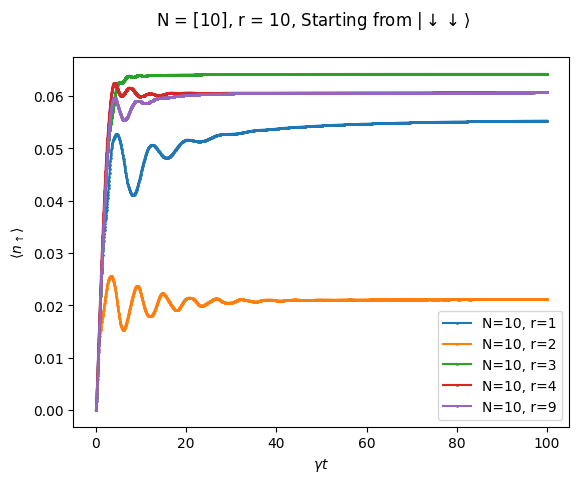

In [12]:
fig, ax = subplots()
for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        if j ∉ nbr_error_t_N[i]
            if line == []
                line, = ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label="N=$(N_list[i]), r=$j") # N_list[i]
            else
                ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label="N=$(N_list[i]), r=$j") # , color=line.get_color(),
            end
        end
    end
end


ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.legend()

suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf();
# pygui(true); show()

# Plot avg signal without first values

In [13]:
function runmean_window_t(array, T, window_t)
    mean_array = []
    for i = 1:length(array)
        if T[i] > window_t
            push!(mean_array, mean(array[abs.(T .- T[i]) .< window_t]))
        end
    end
    return mean_array
end

function derivate(array, T)
    deriv = []
    for i in 2:length(array)
        push!(deriv, (array[i]-array[i-1])/(T[i]-T[i-1]))
    end
    return deriv
end

derivate (generic function with 1 method)

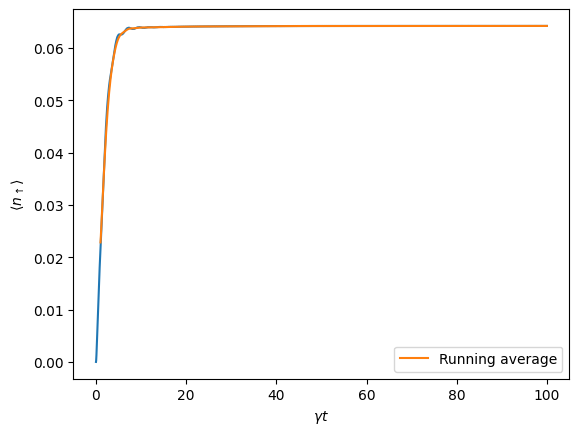

In [14]:
window_t = 1
popup, T =  popup_t_N[1][3], list_t_N[1][3]
popup_mean = runmean_window_t(popup, T, window_t)

close("all")
plot(T, popup)
plot(T[T .> window_t], popup_mean, label="Running average")

# plot(T[T .> window_t], popup_mean, label="Running average")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
legend()
pygui(false); gcf();
# pygui(true); show()

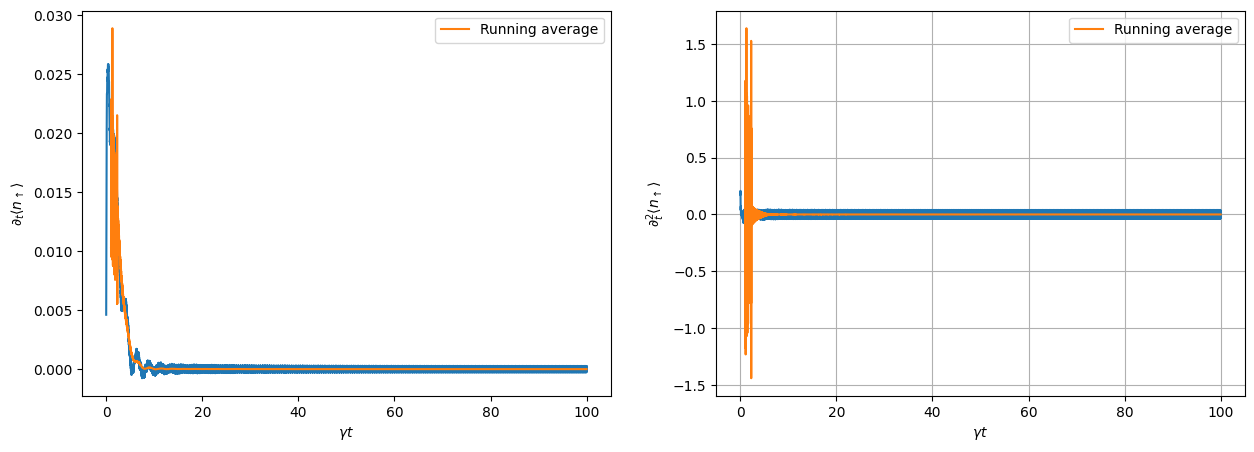

In [15]:
figure, axes = subplots(1, 2, figsize=(15, 5))
axes[1].plot(T[1:end-1], derivate(popup, T))
axes[1].plot(T[T .> window_t][1:end-1], derivate(popup_mean, T[T .> window_t]), label="Running average")
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")
axes[1].legend()

axes[2].plot(T[1:end-2], derivate(derivate(popup, T), T[1:end-1]))
axes[2].plot(T[T .> window_t][1:end-2], derivate(derivate(popup_mean,  T[T .> window_t]),  T[T .> window_t][1:end-1]), label="Running average")
axes[2].set_xlabel(L"$\gamma t$")
axes[2].set_ylabel(L"$\partial_t^2\langle  n_{\uparrow} \rangle $")
axes[2].grid()
axes[2].legend()

pygui(false); gcf();
# pygui(true); show()

In [16]:
function boxmean_window_t(array, T, window_t)
    boxes_mean = []
    i = 1
    while true
        t_start_window = T[i]
        array_box = []
        while T[i] - t_start_window < window_t
            push!(array_box, array[i])
            if i < length(T)
                i += 1
            else
                push!(boxes_mean, mean(array_box))
                return boxes_mean
            end
        end
        push!(boxes_mean, mean(array_box))
    end
end


boxmean_window_t (generic function with 1 method)

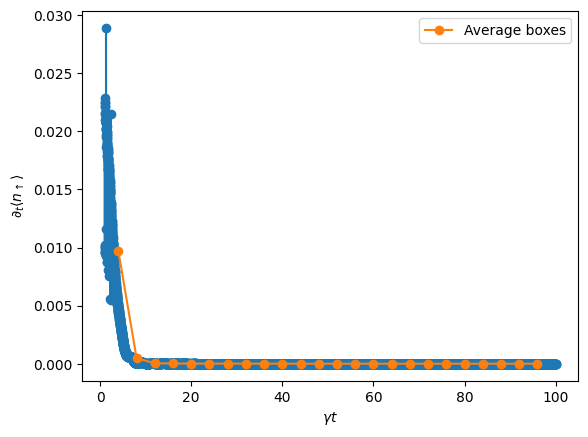

In [17]:
window_var = 4
derivative_avg = derivate(popup_mean, T[T .> window_t])


close("all")
plot(T[T .> window_t][1:end-1], derivative_avg, marker="o")
plot([i*window_var for i in 1:div(T[end], window_var)-1], boxmean_window_t(derivative_avg, T[T .> window_var][1:end-1], window_var), label="Average boxes", marker="o")
xlabel(L"$\gamma t$")
ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")
legend()
pygui(false); gcf();
# pygui(true); show()

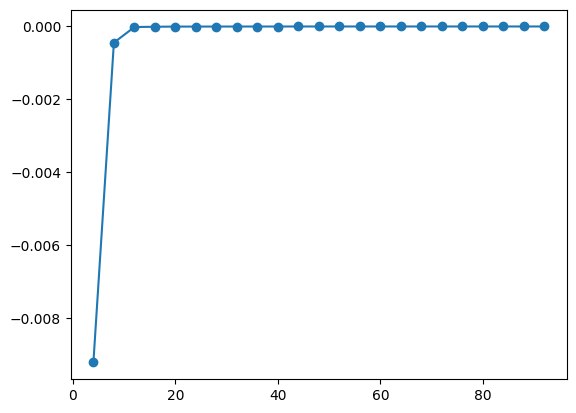

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021360FD2C10>

In [18]:
boxes_deriv = boxmean_window_t(derivative_avg, T[T .> window_var][1:end-1], window_var)
plot([i*window_var for i in 1:div(T[end], window_var)-2], boxes_deriv[2:end] - boxes_deriv[1:end-1], marker="o")

# Plot for all repetitions

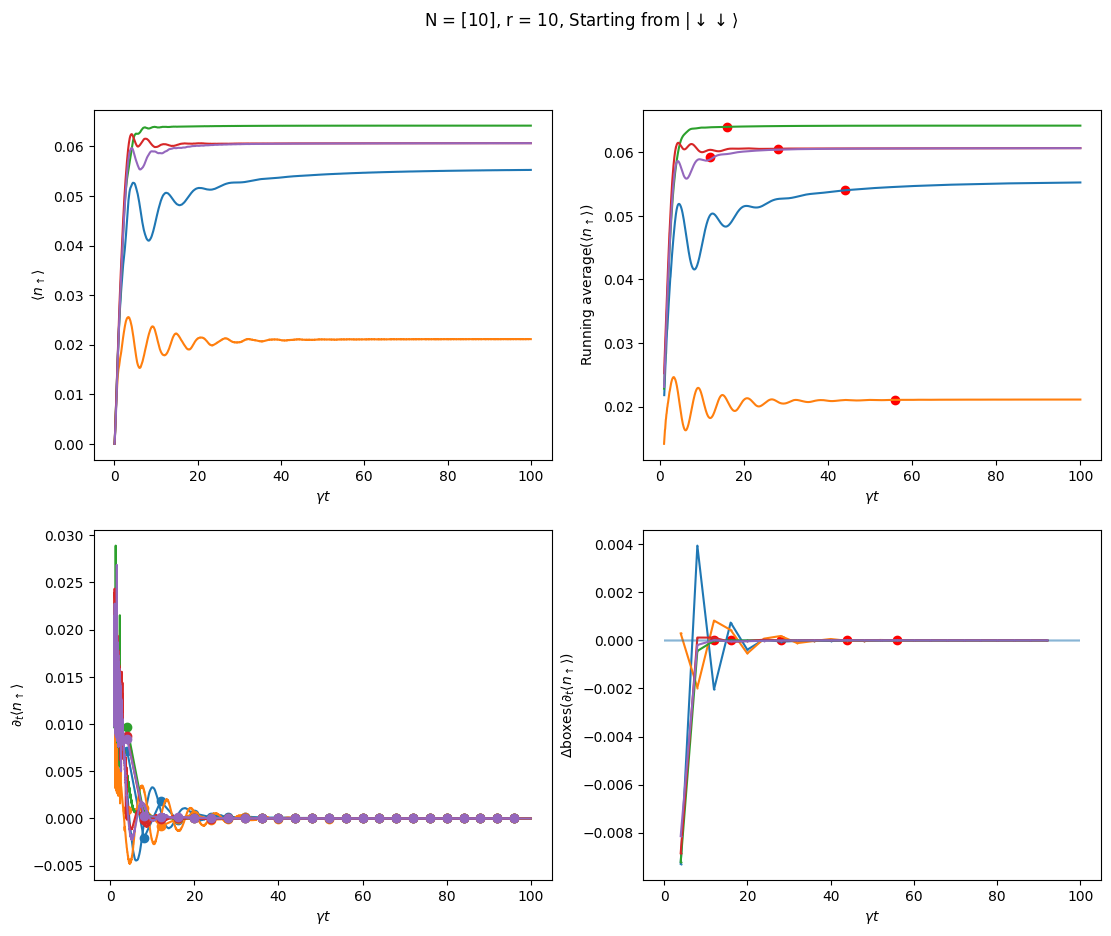

In [20]:
window_t = 1
window_var = 4
threshold_box_deriv = 1e-5

close("all")
fig, axes = subplots(2, 2, figsize=(13, 10))

for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        if j ∉ nbr_error_t_N[i]
            popup, T = popup_t_N[i][j], list_t_N[i][j]
            # if line == []
                line, = axes[1].plot(list_t_N[i][j], popup_t_N[i][j])#, marker="o", markersize=1) # , label="N=$(N_list[i]), r=$j" N_list[i]
            # else
                # axes[1].plot(list_t_N[i][j], popup_t_N[i][j])#, marker="o", markersize=1) # , color=line.get_color(),, label="N=$(N_list[i]), r=$j"
            # end

            popup_mean = runmean_window_t(popup, T, window_t)
            axes[1, 2].plot(T[T .> window_t], popup_mean, color=line.get_color())

            derivative_avg = derivate(popup_mean, T[T .> window_t])
            boxes_deriv = boxmean_window_t(derivative_avg, T[T .> window_var][1:end-1], window_var)
            axes[2, 1].plot(T[T .> window_t][1:end-1], derivative_avg, color=line.get_color())
            axes[2, 1].plot([i*window_var for i in 1:div(T[end], window_var)-1], boxes_deriv, marker="o")

            Delta_box_deriv, T_box_deriv = boxes_deriv[2:end] - boxes_deriv[1:end-1], [i*window_var for i in 1:div(T[end], window_var)-2]
            axes[2, 2].plot(T_box_deriv, Delta_box_deriv, marker="o", markersize=0.5)
            idx_stop_deriv = findfirst(abs.(Delta_box_deriv) .< threshold_box_deriv)

            if idx_stop_deriv !=  nothing
                axes[2, 2].scatter(T_box_deriv[idx_stop_deriv], Delta_box_deriv[idx_stop_deriv], marker="o", color="r")
                axes[2, 2].hlines(threshold_box_deriv, 0, t_end, linewidth=0.1), axes[2, 2].hlines(-threshold_box_deriv, 0, t_end, linewidth=0.1)

                idx_stop = argmin(abs.(T .- T_box_deriv[idx_stop_deriv]))
                axes[1, 2].scatter(T[idx_stop], popup_mean[idx_stop], color="r")
            end


        end
    end
end


axes[1, 1].set_xlabel(L"$\gamma t$")
axes[1, 1].set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

axes[1, 2].set_xlabel(L"$\gamma t$")
axes[1, 2].set_ylabel(L"Running average($\langle  n_{\uparrow} \rangle $)")

axes[2, 1].set_xlabel(L"$\gamma t$")
axes[2, 1].set_ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")

axes[2, 2].set_xlabel(L"$\gamma t$")
axes[2, 2].set_ylabel(L"$\Delta $boxes($\partial_t\langle  n_{\uparrow} \rangle $)")

suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf();
# pygui(true); show()

Vector{Int64} (alias for Array{Int64, 1})

# With boxes directly on the mean

### Plot averaged signal

In [ ]:
function runmean_window_t(array, T, window_t)
    mean_array = []
    for i = 1:length(array)
        push!(mean_array, mean(array[abs.(T .- T[i]) .< window_t]))
    end
    return mean_array
end

function derivate(array, T)
    deriv = []
    for i in 2:length(array)
        push!(deriv, (array[i]-array[i-1])/(T[i]-T[i-1]))
    end
    return deriv
end

derivate (generic function with 1 method)

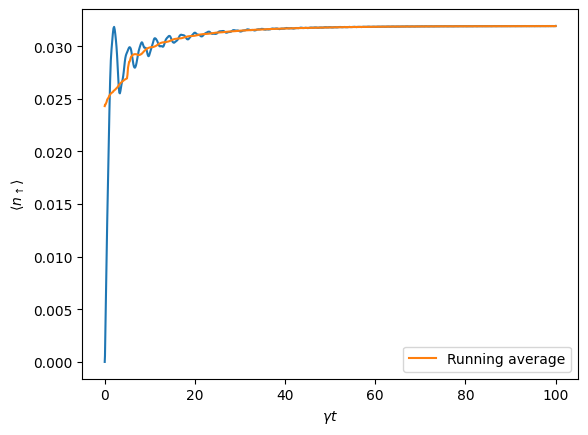

In [ ]:
window_t = 5
popup, T =  popup_t_N[1][3], list_t_N[1][3]
popup_mean = runmean_window_t(popup, T, window_t)

close("all")
plot(T, popup)
plot(T, popup_mean, label="Running average")

# plot(T[T .> window_t], popup_mean, label="Running average")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
legend()
pygui(false); gcf();
# pygui(true); show()

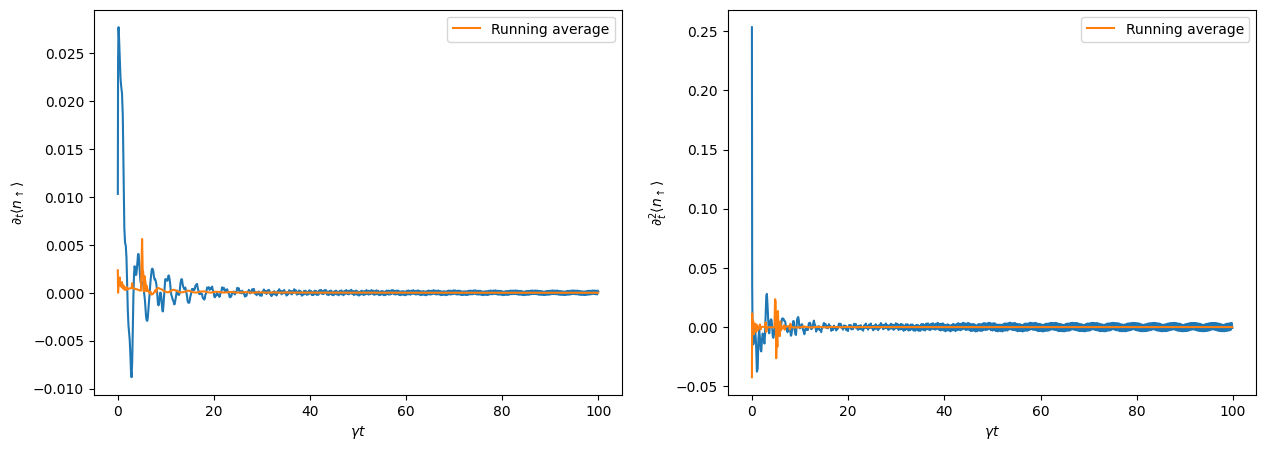

In [ ]:
figure, axes = subplots(1, 2, figsize=(15, 5))
axes[1].plot(T[1:end-1], derivate(popup, T))
axes[1].plot(T[1:end-1], derivate(popup_mean, T), label="Running average")
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\partial_t\langle  n_{\uparrow} \rangle $")
axes[1].legend()

axes[2].plot(T[1:end-2], derivate(derivate(popup, T), T[1:end-1]))
axes[2].plot(T[1:end-2], derivate(derivate(popup_mean,  T),  T[1:end-1]), label="Running average")
axes[2].set_xlabel(L"$\gamma t$")
axes[2].set_ylabel(L"$\partial_t^2\langle  n_{\uparrow} \rangle $")
axes[2].legend()

pygui(false); gcf();
# pygui(true); show()